# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn import tree
from google.colab import files
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier


# Carga de los data sets de test y de entrenamiento

In [3]:
test = pd.read_csv('https://raw.githubusercontent.com/FerFabbiano/tp2-organizacionDeDatos/main/Test_TP2_Datos_2020-2C.csv')
train = pd.read_csv('https://raw.githubusercontent.com/FerFabbiano/tp2-organizacionDeDatos/main/Train_TP2_Datos_2020-2C.csv')

train_set_features = pd.read_csv('https://raw.githubusercontent.com/FerFabbiano/tp2-organizacionDeDatos/main/train_set_Features.csv')
test_set_features = pd.read_csv('https://raw.githubusercontent.com/FerFabbiano/tp2-organizacionDeDatos/main/test_set_Features.csv')

In [4]:
train_set_features = train_set_features.drop_duplicates(subset="Opportunity_ID")
test_set_features = test_set_features.drop_duplicates(subset="Opportunity_ID")

Separamos la variable a predecir. Esta vez vamos a utilizar el data frame procesado, que contiene el feature "Total Taxable Amount USD".

In [5]:
#X = DATA , Y = TARGET 
X1, y1 = train_set_features[['Total_Taxable_Amount_USD',
                            'Bureaucratic_Code_0_Approved', 
                            'Products_Per_Op',
                            'TRF_Per_Op',
                            'Daily_Dif_Account_Created_Opportunity_Created_Date',
                            'Opp_Owner_Did_Last_Modifiy',
                            'Pricing, Delivery_Terms_Approved',
                            'Bureaucratic_Code_0_Approval',
                            'Last_Modified_date>Planned_Delivery_End_Date',
                            'Op_Has_A_Valid_Quote_Expiry_Date']], train_set_features['Stage']

Dividimos el set de entrenamiento en train y test, utilizando una proporción del 30% del total de los datos para el segundo.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.3, random_state=45)

# Random Forest

Tenemos que encodear la variable a predecir para que sea una variable numérica. Usamos Label Encoding.

In [7]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_train)

LabelEncoder()

Instanciamos el clasificador de Random Forest, y entrenamos el modelo.

In [8]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, le.transform(y_train))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Entrenamos el modelo.

In [9]:
predicciones_train = rf_clf.predict_proba(X_test)

In [10]:
from sklearn.metrics import log_loss, make_scorer
log_loss(y_test, predicciones_train)

0.5889246095213696

Analizamos la importancia de cada uno de los features que utilizamos.

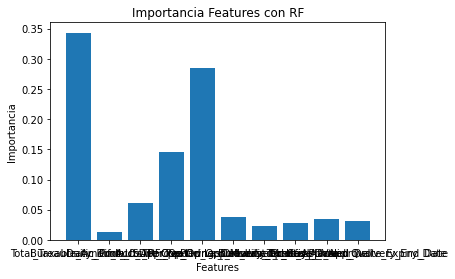

In [11]:
plt.bar(X_train.columns, rf_clf.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia Features con RF')
plt.show()



# Random Search

In [12]:
posibles_hiperparametros = {'n_estimators':np.arange(1, 50, 5),
                             'max_depth':np.arange(1, 7, 1),
                              'min_samples_split': np.arange(2,10,1),
                            'min_samples_leaf': np.arange(1,10, 1)}

random_search_hp = RandomizedSearchCV(RandomForestClassifier(), 
                                      posibles_hiperparametros, 
                                      n_iter = 1000,
                                      scoring=make_scorer(log_loss, 
                                                          greater_is_better=False,
                                                          needs_proba=True),
                                      return_train_score=True)

random_search_hp.fit(X_train, le.transform(y_train))

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
            

In [13]:
random_search_hp.best_params_

{'max_depth': 6,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 41}

In [14]:
predicciones_mejores_hp_train = random_search_hp.predict_proba(X_test)

In [15]:
from sklearn.metrics import log_loss
log_loss(y_test, predicciones_mejores_hp_train)

0.5070568224321879

In [16]:
predicciones_finales = random_search_hp.predict_proba(test_set_features[['Total_Taxable_Amount_USD',
                            'Bureaucratic_Code_0_Approved', 
                            'Products_Per_Op',
                            'TRF_Per_Op',
                            'Daily_Dif_Account_Created_Opportunity_Created_Date',
                            'Opp_Owner_Did_Last_Modifiy',
                            'Pricing, Delivery_Terms_Approved',
                            'Bureaucratic_Code_0_Approval',
                            'Last_Modified_date>Planned_Delivery_End_Date',
                            'Op_Has_A_Valid_Quote_Expiry_Date']])

In [23]:
predicciones_exito = []
for prob in predicciones_finales:
  predicciones_exito.append(prob[1])

In [24]:
csv_kaggle = pd.DataFrame()
csv_kaggle['Opportunity_ID'] = test_set_features["Opportunity_ID"]
csv_kaggle['target'] = predicciones_exito

In [25]:
csv = csv_kaggle.to_csv('predicciones_random_forest.csv', index=False)
files.download('predicciones_random_forest.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Resultados

Algoritmo: **Random Forest**

Búsqueda de hiper parámetros: **Random Search**

Features analizados:
- Total_Taxable_Amount_- ,
- Bureaucratic_Code_0_Appro- , 
- Products_Per- ,
- TRF_Per- ,
- Daily_Dif_Account_Created_Opportunity_Created_D- ,
- Opp_Owner_Did_Last_Modi- ,
- Pricing, Delivery_Terms_Appro- ,
- Bureaucratic_Code_0_Appro- ,
- Last_Modified_date>Planned_Delivery_End_D- ,
- Op_Has_A_Valid_Quote_Expiry_D- 

Hiper parámetros: 

- max_depth: 6 
- min_samples_leaf: 2 
- min_samples_split: 5 
- n_estimators: 42

**Resultado Kaggle = 0,**